# Vision Transformers

Referências:

- [ViT Video](https://youtu.be/ovB0ddFtzzA)
- [Código Original](https://github.com/jankrepl/mildlyoverfitted/blob/master/github_adventures/vision_transformer/verify.py)
- [Timm Git](https://github.com/rwightman/pytorch-image-models)

In [10]:
import numpy as np
import torch
import torch.nn as nn

# Patch Embedding

<center><img src="https://la.mathworks.com/matlabcentral/mlc-downloads/downloads/submissions/40173/versions/3/screenshot.jpg"/></center>

In [11]:
class PatchEmbed(nn.Module):
    """Split image into patches and then embed them.

    Parameters
    ----------
    img_size : int
        Size of the image (it is a square).
    patch_size : int
        Size of the patch (it is a square).
    in_chans : int
        Number of input channels.
    embed_dim : int
        The emmbedding dimension.

    Attributes
    ----------
    n_patches : int
        Number of patches inside of our image.
    proj : nn.Conv2d
        Convolutional layer that does both the splitting into patches
        and their embedding.
    """

    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size)**2

        # Split the image using a convolution (without overlap).
        self.proj = nn.Conv2d(
            in_channels=in_chans,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches, embed_dim)`.
        """
        x = self.proj(x)    # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x = x.flatten(2)    # (n_samples, embed_dim, n_patches)
        x = x.transpose(1, 2)    # (n_samples, n_patches, embed_dim)

        return x

# Attention

<center><img src="https://miro.medium.com/max/1270/1*LpDpZojgoKTPBBt8wdC4nQ.png" width="700"/> <img src="https://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png" width="700"/></center>


In [12]:
class Attention(nn.Module):
    """Attention mechanism.
    Parameters
    ----------
    dim : int
        The input and out dimension of per token features.
    n_heads : int
        Number of attention heads.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    attn_p : float
        Dropout probability applied to the query, key and value tensors.
    proj_p : float
        Dropout probability applied to the output tensor.

    Attributes
    ----------
    scale : float
        Normalizing consant for the dot product.
    qkv : nn.Linear
        Linear projection for the query, key and value.
    proj : nn.Linear
        Linear mapping that takes in the concatenated output of all attention
        heads and maps it into a new space.
    attn_drop, proj_drop : nn.Dropout
        Dropout layers.
    """

    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0.0, proj_p=0.0):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads

        self.head_dim = dim // n_heads

        # Feeding extremely large values into the softmax could lead into small gradients
        self.scale = 1 / np.sqrt(self.head_dim)    # Stabilize gradients (√dk)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)    # Split the embedding into Q, K, V
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)    # ... => Concat => *Linear* => Output => ...
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """

        # Input and output tensors are going to have the same shape
        # Class token as the first token in the sequence

        n_samples, n_tokens, dim = x.shape

        if dim != self.dim:
            raise ValueError

        # The input tensor's last dimension must be equal to the input features in the constructor.
        qkv = self.qkv(x)    # (n_samples, n_patches + 1, 3 * dim)

        # Create an extra dimension for the heads and an extra dimension for the key-query-value
        qkv = qkv.reshape(n_samples, n_tokens, 3, self.n_heads,
                          self.head_dim)    # (n_smaples, n_patches + 1, 3, n_heads, head_dim)

        # Change the dimension order so it is easy to extract the keys, queries and values
        qkv = qkv.permute(2, 0, 3, 1, 4)    # (3, n_samples, n_heads, n_patches + 1, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Create a variable KT to calculate the dot product
        k_t = k.transpose(-2, -1)    # (n_samples, n_heads, head_dim, n_patches + 1)
        score = (q@k_t) * self.scale    # (n_samples, n_heads, n_patches + 1, n_patches + 1)

        # Apply a softmax over the last dimension.
        attn = score.softmax(dim=-1)    # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = self.attn_drop(attn)

        # z = soft * value
        weighted_avg = attn@v    # (n_samples, n_heads, n_patches +1, head_dim)
        weighted_avg = weighted_avg.transpose(1, 2)    # (n_samples, n_patches + 1, n_heads, head_dim)

        # Concatenate heads
        weighted_avg = weighted_avg.flatten(2)    # (n_samples, n_patches + 1, dim)

        x = self.proj(weighted_avg)    # (n_samples, n_patches + 1, dim)
        x = self.proj_drop(x)    # (n_samples, n_patches + 1, dim)

        return x


# Encoder

<center><img src="https://pytorch.org/assets/images/2022-7-12-a-better-transformer-for-fast-transformer-encoder-inference-1.png" width="800"/></center>


In [13]:
class MLP(nn.Module):
    """Multilayer perceptron.
    Parameters
    ----------
    in_features : int
        Number of input features.
    hidden_features : int
        Number of nodes in the hidden layer.
    out_features : int
        Number of output features.
    p : float
        Dropout probability.

    Attributes
    ----------
    fc : nn.Linear
        The First linear layer.
    act : nn.GELU
        GELU activation function.
    fc2 : nn.Linear
        The second linear layer.
    drop : nn.Dropout
        Dropout layer.
    """

    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, in_features)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches +1, out_features)`
        """
        x = self.fc1(x)    # (n_samples, n_patches + 1, hidden_features)
        x = self.act(x)    # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)    # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x)    # (n_samples, n_patches + 1, out_features)
        x = self.drop(x)    # (n_samples, n_patches + 1, out_features)

        return x


In [14]:
class Block(nn.Module):
    """Transformer block.
    Parameters
    ----------
    dim : int
        Embeddinig dimension.
    n_heads : int
        Number of attention heads.
    mlp_ratio : float
        Determines the hidden dimension size of the `MLP` module with respect
        to `dim`.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    p, attn_p : float
        Dropout probability.

    Attributes
    ----------
    norm1, norm2 : LayerNorm
        Layer normalization.
    attn : Attention
        Attention module.
    mlp : MLP
        MLP module.
    """

    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0.0, attn_p=0.0):
        super().__init__()
        # Layer norm: y =​ (x−E[x]/√Var[x]+ϵ) ​∗ γ + β​
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, n_heads=n_heads, qkv_bias=qkv_bias, attn_p=attn_p, proj_p=p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(
            in_features=dim,
            hidden_features=hidden_features,
            out_features=dim,
        )

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """

        # Residual connections
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        return x


# ViT

In [15]:
class VisionTransformer(nn.Module):
    """Simplified implementation of the Vision transformer.
    Parameters
    ----------
    img_size : int
        Both height and the width of the image (it is a square).
    patch_size : int
        Both height and the width of the patch (it is a square).
    in_chans : int
        Number of input channels.
    n_classes : int
        Number of classes.
    embed_dim : int
        Dimensionality of the token/patch embeddings.
    depth : int
        Number of blocks.
    n_heads : int
        Number of attention heads.
    mlp_ratio : float
        Determines the hidden dimension of the `MLP` module.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    p, attn_p : float
        Dropout probability.

    Attributes
    ----------
    patch_embed : PatchEmbed
        Instance of `PatchEmbed` layer.
    cls_token : nn.Parameter
        Learnable parameter that will represent the first token in the sequence.
        It has `embed_dim` elements.
    pos_emb : nn.Parameter
        Positional embedding of the cls token + all the patches.
        It has `(n_patches + 1) * embed_dim` elements.
    pos_drop : nn.Dropout
        Dropout layer.
    blocks : nn.ModuleList
        List of `Block` modules.
    norm : nn.LayerNorm
        Layer normalization.
    """

    def __init__(
        self,
        img_size=384,
        patch_size=16,
        in_chans=3,
        n_classes=1000,
        embed_dim=768,
        depth=12,
        n_heads=12,
        mlp_ratio=4.,
        qkv_bias=True,
        p=0.0,
        attn_p=0.0,
    ):
        super().__init__()

        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
        )

        # Class Token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # +1: We also want to learn the positional encoding for the class token
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)

        # Transformer encoder. Each of the blocks will have its own learnable parameters.
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim,
                n_heads=n_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                p=p,
                attn_p=attn_p,
            ) for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)

        # Input the final embeddfing of the Class Token and output the probabilities over all the classes. 
        self.head = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        """Run the forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.

        Returns
        -------
        logits : torch.Tensor
            Logits over all the classes - `(n_samples, n_classes)`.
        """

        n_samples = x.shape[0]

        # The input tensor is a batch of images, so we turn them into patch embeddings
        x = self.patch_embed(x)

        cls_token = self.cls_token.expand(n_samples, -1, -1)    # (n_samples, 1, embed_dim)

        # Prepend the class tokens to the patch embeddings
        x = torch.cat((cls_token, x), dim=1)    # (n_samples, 1 + n_patches, embed_dim)

        # Positional embedding and dropout
        x = x + self.pos_embed    # (n_samples, 1 + n_patches, embed_dim)
        x = self.pos_drop(x)

        # Run through all the blocks of the transformer encoder
        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        # This embedding should encode the meaning of the entire image
        cls_token_final = x[:, 0]    # just the CLS token
        x = self.head(cls_token_final)

        return x

In [16]:
try:
    import timm
except:
    print("Import failed")
    # !pip install timm
    # import timm

def get_n_params(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)


def assert_tensors_equal(t1, t2):
    a1, a2 = t1.detach().numpy(), t2.detach().numpy()

    np.testing.assert_allclose(a1, a2)


model_name = "vit_base_patch16_384"
model_official = timm.create_model(model_name, pretrained=True)
model_official.eval()
print(type(model_official))

custom_config = {
    "img_size": 384,
    "in_chans": 3,
    "patch_size": 16,
    "embed_dim": 768,
    "depth": 12,
    "n_heads": 12,
    "qkv_bias": True,
    "mlp_ratio": 4,
}

model_custom = VisionTransformer(**custom_config)
model_custom.eval()

for (n_o, p_o), (n_c, p_c) in zip(model_official.named_parameters(), model_custom.named_parameters()):
    assert p_o.numel() == p_c.numel()
    # print(f"{n_o} | {n_c}")

    p_c.data[:] = p_o.data

    assert_tensors_equal(p_c.data, p_o.data)

inp = torch.rand(1, 3, 384, 384)
res_c = model_custom(inp)
res_o = model_official(inp)

# Asserts
assert get_n_params(model_custom) == get_n_params(model_official)
assert_tensors_equal(res_c, res_o)

# Save custom model
torch.save(model_custom, "model.pth")

<class 'timm.models.vision_transformer.VisionTransformer'>


In [17]:
from PIL import Image
import requests
import urllib.request


def transformers_get_class(link):
    k = 10
    urllib.request.urlretrieve("https://raw.githubusercontent.com/jankrepl/mildlyoverfitted/master/github_adventures/vision_transformer/classes.txt",
                               "classes.txt")
    imagenet_labels = dict(enumerate(open("classes.txt")))

    # Get image
    urllib.request.urlretrieve(link, "img.png")
    img = Image.open('img.png')
    img = img.resize((384, 384))
    display(img)

    # Get model
    model = torch.load("model.pth")
    model.eval()

    img = (np.array(img) / 128) - 1    # in the range -1, 1
    inp = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to(torch.float32)
    logits = model(inp)
    probs = torch.nn.functional.softmax(logits, dim=-1)

    top_probs, top_ixs = probs[0].topk(k)

    for i, (ix_, prob_) in enumerate(zip(top_ixs, top_probs)):
        ix = ix_.item()
        prob = prob_.item()
        cls = imagenet_labels[ix].strip()
        print(f"{i}: {cls:<50} --- {prob:.4f}")

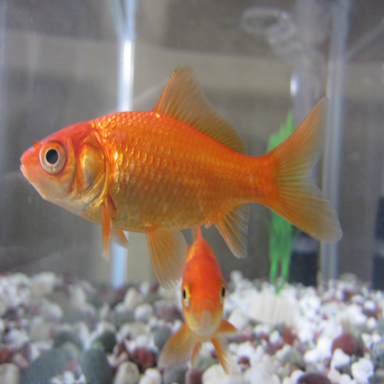

0: goldfish, Carassius_auratus                        --- 0.9985
1: tench, Tinca_tinca                                 --- 0.0001
2: axolotl, mud_puppy, Ambystoma_mexicanum            --- 0.0001
3: terrapin                                           --- 0.0001
4: gar, garfish, garpike, billfish, Lepisosteus_osseus --- 0.0000
5: anemone_fish                                       --- 0.0000
6: electric_ray, crampfish, numbfish, torpedo         --- 0.0000
7: puffer, pufferfish, blowfish, globefish            --- 0.0000
8: eel                                                --- 0.0000
9: starfish, sea_star                                 --- 0.0000


In [19]:
link = "https://upload.wikimedia.org/wikipedia/commons/b/b9/%E3%83%AF%E3%82%AD%E3%83%B320120701.JPG"
transformers_get_class(link)